In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



In [2]:
training_data = image_dataset_from_directory(
    '../data/chest_xray/train', 
    labels='inferred',
    validation_split = 0.2,
    subset="training",
    seed=14)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


In [3]:
validation_data = image_dataset_from_directory(
    '../data/chest_xray/train', 
    labels='inferred',
    validation_split = 0.2,
    subset="validation",
    seed=14)

Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [4]:
test_data = image_dataset_from_directory(
    '../data/chest_xray/test', 
    labels='inferred',
    batch_size = 624,
    shuffle = False)

Found 624 files belonging to 2 classes.


In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [6]:
aug_ds = training_data.map( lambda x, y: (data_augmentation(x, training=True), y))
augmented_training_data = training_data.concatenate(aug_ds)

In [7]:
aug_val = validation_data.map( lambda x, y: (data_augmentation(x, training=True), y))
augmented_validation_data = validation_data.concatenate(aug_val)

In [8]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224,224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [9]:
augmented_training_data = augmented_training_data.shuffle(1000)
augmented_training_data = augmented_training_data.map(preprocess).prefetch(1)
augmented_validation_data = augmented_validation_data.map(preprocess).prefetch(1)
test_data = test_data.map(preprocess).prefetch(1)

In [10]:
augmented_training_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
base_model = keras.applications.xception.Xception(weights = 'imagenet', include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation = 'sigmoid')(avg)
model = keras.Model(inputs = base_model.input, outputs = output)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = keras.optimizers.SGD(lr = 0.2, momentum = 0.9, decay = 0.01)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
results = model.fit(augmented_training_data, epochs = 5, validation_data = augmented_validation_data, class_weight = {0:2.88, 1:1})


In [ ]:
model.evaluate(test_data)

In [ ]:
#model.save('Kyle_transfer_2')

# Run for a few epochs, then unfreeze the bottom layers and resume training below

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

In [18]:
optimizer = keras.optimizers.SGD(lr = 0.01, momentum = 0.9, decay = 0.001)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

NameError: name 'model' is not defined

In [ ]:
results = model.fit(augmented_training_data, epochs = 5, validation_data = augmented_validation_data, class_weight = {0:2.88, 1:1})

In [ ]:
model.evaluate(test_data)

In [ ]:
model.save('Kyle_transfer_full_5')

In [16]:
reconstructed_model = keras.models.load_model("../models/Kyle_transfer_full_2")

In [17]:
reconstructed_model.evaluate(test_data)

1/1 [==============================] - 0s 23ms/step - loss: 0.6127 - accuracy: 0.9071


[0.6127194166183472, 0.9070512652397156]

In [20]:
optimizer = keras.optimizers.SGD(lr = 0.01, momentum = 0.9, decay = 0.001)
reconstructed_model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [25]:
results = reconstructed_model.fit(augmented_training_data, epochs = 5, validation_data = augmented_validation_data, class_weight = {0:2.88, 1:1})

Epoch 1/5
262/262 [==============================] - 2142s 8s/step - loss: 0.0356 - accuracy: 0.9911 - val_loss: 0.0572 - val_accuracy: 0.9779
Epoch 2/5
262/262 [==============================] - 2168s 8s/step - loss: 0.0196 - accuracy: 0.9950 - val_loss: 0.0687 - val_accuracy: 0.9789
Epoch 3/5
262/262 [==============================] - 2181s 8s/step - loss: 0.0281 - accuracy: 0.9939 - val_loss: 0.0786 - val_accuracy: 0.9751
Epoch 4/5
262/262 [==============================] - 2169s 8s/step - loss: 0.0279 - accuracy: 0.9932 - val_loss: 0.0461 - val_accuracy: 0.9827
Epoch 5/5
262/262 [==============================] - 2158s 8s/step - loss: 0.0229 - accuracy: 0.9948 - val_loss: 0.0459 - val_accuracy: 0.9856


In [26]:
reconstructed_model.evaluate(test_data)

1/1 [==============================] - 0s 12ms/step - loss: 1.3142 - accuracy: 0.8173


[1.3142019510269165, 0.817307710647583]

In [27]:
reconstructed_model.save('Kyle_transfer_full_4')

INFO:tensorflow:Assets written to: Kyle_transfer_full_4/assets


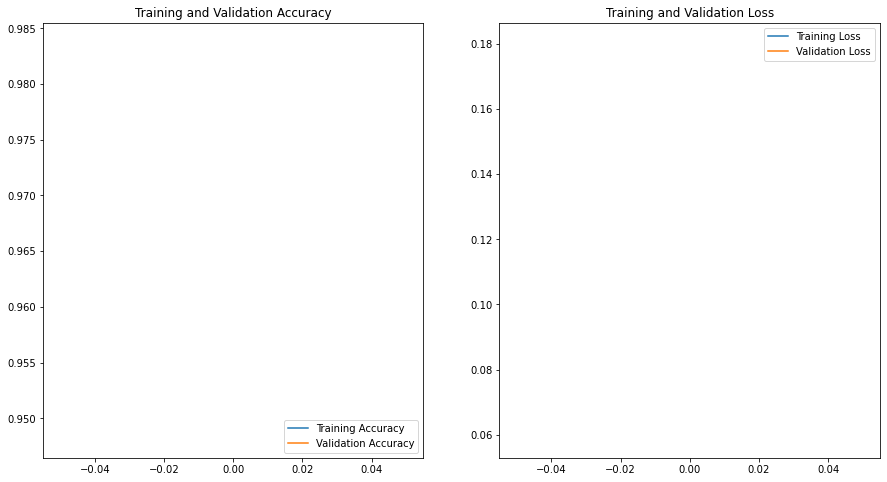

In [24]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

epochs_range = range(1)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
reconstructed_model = keras.models.load_model("Kyle_transfer_full_3")

In [30]:
reconstructed_model.evaluate(test_data)

1/1 [==============================] - 0s 23ms/step - loss: 0.4171 - accuracy: 0.9135


[0.41713327169418335, 0.9134615659713745]

In [31]:
predictions = (reconstructed_model.predict(test_data) > 0.5).astype('int32')

In [32]:
image_batch, labels_batch = next(iter(test_data))

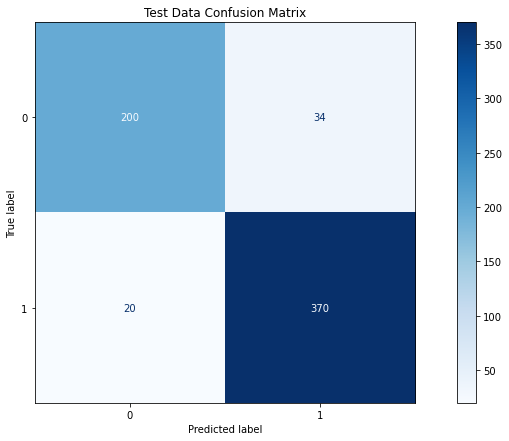

In [33]:
fig, ax = plt.subplots(figsize = (15,7))
ax.set_title('Test Data Confusion Matrix')

labels = training_data.class_names

cm = confusion_matrix(labels_batch, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues, ax = ax);